In [1]:
import pandas as pd

train_h = pd.read_csv("data/train_h_final.csv")
train_no_ads = pd.read_csv("data/train_no_ads_final.csv")

print(train_h.shape)
print(train_no_ads.shape)

(1605, 488)
(14646, 488)


In [2]:
# specifices which cols to drop
# column names that contain these text will be dropped
cols_to_drop = []

def get_cols(df, cols_to_drop):
    cols = []
    for col in cols_to_drop:
        cols.append([c for c in df.columns if col in c])
    return cols

## Basic Data Cleaning

Remove columns with missing values or all zeros.

Remove rows with empty structures.

In [3]:
print(f"columns in h-ads dataset before: {train_h.shape[1]}")
print(f"columns in no-ads dataset before: {train_no_ads.shape[1]}")
print(f"rows in h-ads dataset before: {train_h.shape[0]}")
print(f"rows in no-ads dataset before: {train_no_ads.shape[0]}")

# get features with all NaN values
h_nan_cols = train_h.columns[train_h.isna().all()].tolist()
no_ads_nan_cols = train_no_ads.columns[train_no_ads.isna().all()].tolist()

# get features with all 0 values
h_numeric_cols = train_h.select_dtypes(include='number')
h_zero_cols = h_numeric_cols.columns[h_numeric_cols.eq(0).all()]

no_ads_num_cols = train_no_ads.select_dtypes(include='number')
no_ads_zero_cols = no_ads_num_cols.columns[no_ads_num_cols.eq(0).all()]

print("----")
print("Columns with all missing values in h-ads dataset:", h_nan_cols)
print("Columns with all missing values in no-ads dataset:", no_ads_nan_cols)
print("0-value columns in h-ads dataset:", h_zero_cols)
print("0-value columns in no-ads dataset:", no_ads_zero_cols)

# drop bad columns and rows
train_h = train_h.drop(columns=h_nan_cols).drop(columns=h_zero_cols).dropna(subset=['structure']).reset_index(drop=True)
train_no_ads = train_no_ads.drop(columns=no_ads_nan_cols).drop(columns=no_ads_zero_cols).dropna(subset=['structure']).reset_index(drop=True)

print("----")
print(f"columns in h-ads dataset after cleaning: {train_h.shape[1]}")
print(f"columns in no-ads dataset after cleaning: {train_no_ads.shape[1]}")

print(f"rows in h-ads dataset after cleaning: {train_h.shape[0]}")
print(f"rows in no-ads dataset after cleaning: {train_no_ads.shape[0]}")

columns in h-ads dataset before: 488
columns in no-ads dataset before: 488
rows in h-ads dataset before: 1605
rows in no-ads dataset before: 14646
----
Columns with all missing values in h-ads dataset: []
Columns with all missing values in no-ads dataset: []
0-value columns in h-ads dataset: Index(['MagpieData minimum NdValence', 'MagpieData minimum NfValence',
       'MagpieData minimum NsUnfilled', 'MagpieData minimum NdUnfilled',
       'MagpieData minimum NfUnfilled', 'MagpieData mode NfUnfilled',
       'MagpieData minimum GSbandgap', 'MagpieData mode GSbandgap',
       'MagpieData minimum GSmagmom'],
      dtype='object')
0-value columns in no-ads dataset: Index(['MagpieData minimum NdValence', 'MagpieData minimum NfValence',
       'MagpieData minimum NsUnfilled', 'MagpieData minimum NdUnfilled',
       'MagpieData minimum NfUnfilled', 'MagpieData minimum GSbandgap',
       'MagpieData minimum GSmagmom'],
      dtype='object')
----
columns in h-ads dataset after cleaning: 479
co

# Step-by-Step Correlation Analysis

It is necessary to perform correlation analysis on each group of features, because we have so many total features.

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# define some helper functions to compute corr matrix and highly correlated pairs
def get_corr_mat(df, show_high_corr_pairs=False, threshold=0.9):
    print(f"computing corr matrix for {len(df.columns)} features")
    corr_mat = df.corr().abs()
    upper_tri = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(bool)) 
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(upper_tri, cmap='coolwarm', center=0, vmin=-1, vmax=1, square=True)
    plt.show()

    if show_high_corr_pairs:
        high_corr_pairs = []
        for column in upper_tri.columns:
            for row in upper_tri.index:
                if abs(upper_tri.loc[row, column]) > threshold:
                    high_corr_pairs.append((row, column, upper_tri.loc[row, column]))

        # Convert the list of pairs to a DataFrame for better readability
        high_corr_df = pd.DataFrame(high_corr_pairs, columns=["Feature 1", "Feature 2", "Correlation"])

        # Sort by absolute correlation value for better inspection
        high_corr_df = high_corr_df.sort_values(by="Correlation", key=abs, ascending=False)

        return high_corr_df

In [5]:
# drop non-numeric columns
train_h_X = train_h.drop(columns=['bulk_id', 'bulk_symbols', 'y_relaxed', 'structure'])
train_no_ads_X = train_no_ads.drop(columns=['bulk_id', 'bulk_symbols', 'y_relaxed', 'structure'])

# hot-encode categorical features
encoded_train_h_X = pd.get_dummies(train_h_X)
encoded_train_no_ads_X = pd.get_dummies(train_no_ads_X)

# get_corr_mat(encoded_train_no_ads_X)

## Check Coloum Matrix Features

computing corr matrix for 198 features


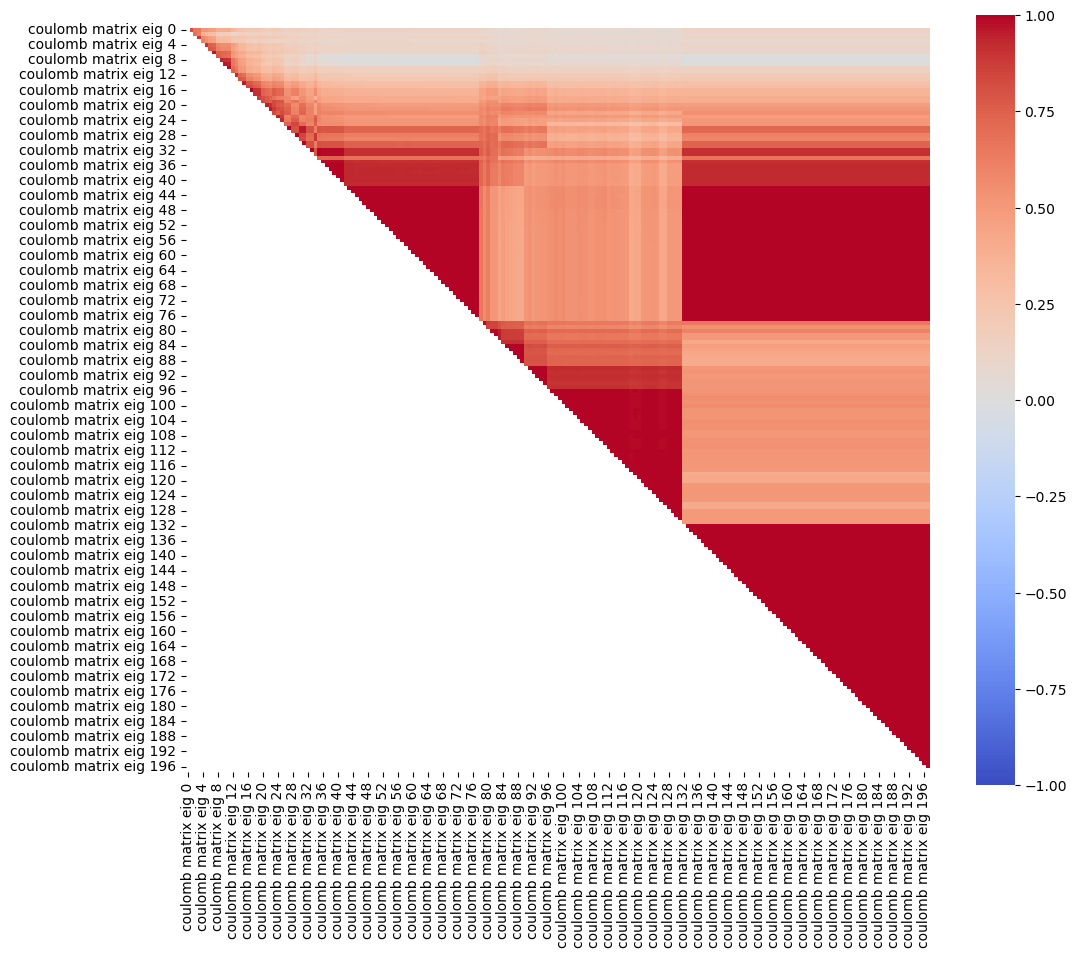

In [6]:
get_corr_mat(train_h[[c for c in train_h.columns if "coulomb matrix eig" in c]])

This looks insane.

In [7]:
# drop all coulomb matrix features
# maybe keep some?
cols_to_drop.append("coulomb matrix eig")

encoded_train_h_X = encoded_train_h_X.drop(columns=[c for c in train_h.columns if "coulomb matrix eig" in c]).reset_index(drop=True)
encoded_train_no_ads_X = encoded_train_no_ads_X.drop(columns=[c for c in train_no_ads.columns if "coulomb matrix eig" in c]).reset_index(drop=True)

## Check HOMO/LUMO Features

computing corr matrix for 103 features


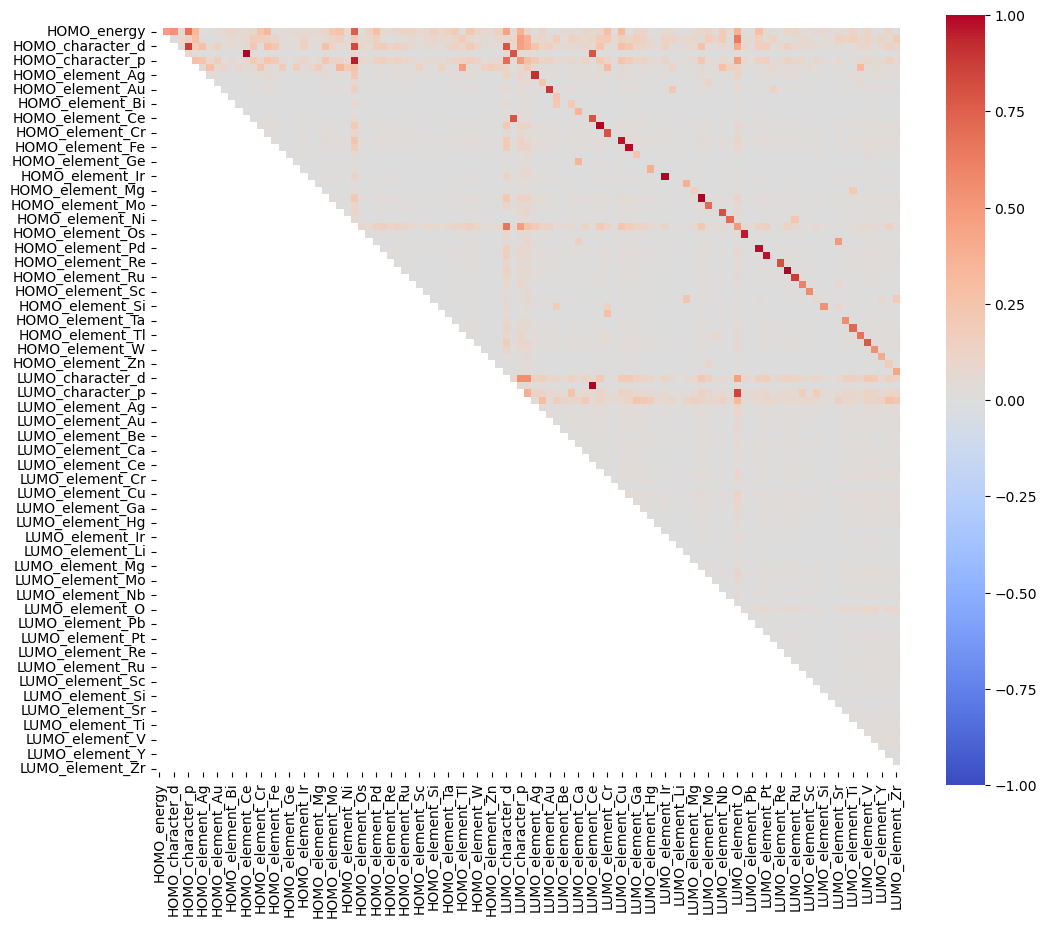

In [8]:
get_corr_mat(encoded_train_h_X[[c for c in encoded_train_h_X.columns if "LUMO" in c or "HOMO" in c]])

HOMO and LUMO columns are almost identical, drop one set

In [9]:
cols_to_drop.append("HOMO")

encoded_train_h_X = encoded_train_h_X.drop(columns=[c for c in encoded_train_h_X.columns if "HOMO" in c]).reset_index(drop=True)
encoded_train_no_ads_X = encoded_train_no_ads_X.drop(columns=[c for c in encoded_train_no_ads_X.columns if "HOMO" in c]).reset_index(drop=True)

## Check MagpieData features

MagpieData gives:
- mode
- mean
- max 
- min
- range
- std dev
- mean local difference
- max local difference
- min local difference
- range local difference
- mean local difference
- avg dev local difference

Check each of these separately and remove highly-correlated pairs

computing corr matrix for 110 features


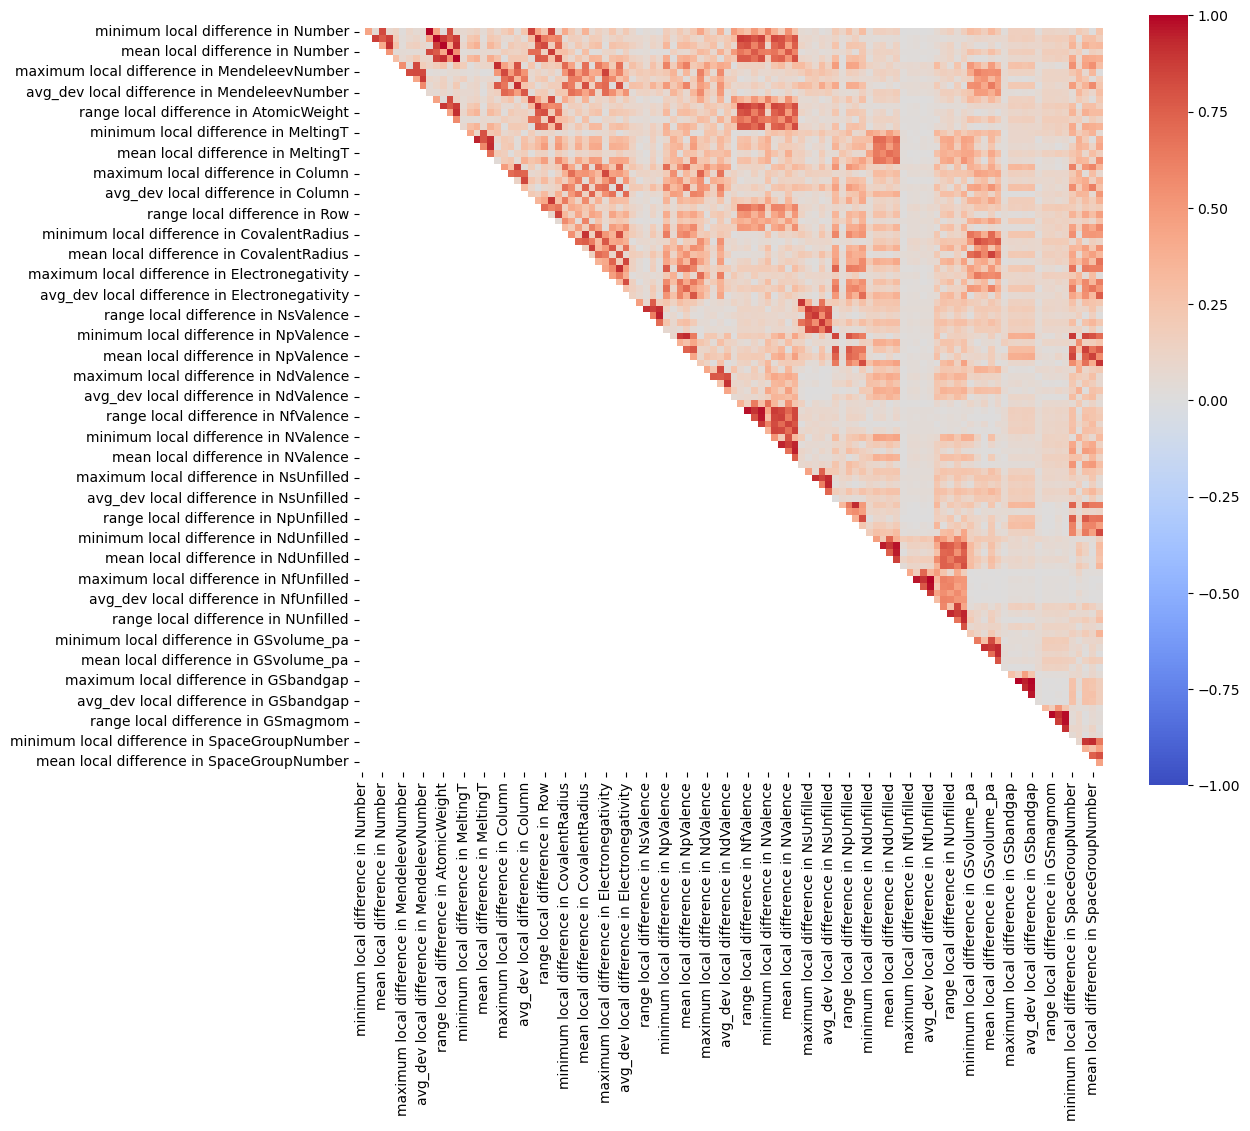

,Feature 1,Feature 2,Correlation
2,maximum local difference in Number,maximum local difference in AtomicWeight,0.999198
5,mean local difference in Number,mean local difference in AtomicWeight,0.998826
3,range local difference in Number,range local difference in AtomicWeight,0.998089
7,avg_dev local difference in Number,avg_dev local difference in AtomicWeight,0.997936
1,minimum local difference in Number,minimum local difference in AtomicWeight,0.997292
45,maximum local difference in GSbandgap,range local difference in GSbandgap,0.993852
37,maximum local difference in NfUnfilled,avg_dev local difference in NfUnfilled,0.993240
48,maximum local difference in GSbandgap,avg_dev local difference in GSbandgap,0.992982
51,maximum local difference in GSmagmom,range local difference in GSmagmom,0.989192
49,range local difference in GSbandgap,avg_dev local difference in GSbandgap,0.988911


In [10]:
get_corr_mat(encoded_train_h_X[[c for c in encoded_train_h_X.columns if "local difference" in c]], True)

In [11]:
# drop all local difference features
cols_to_drop.append("local difference")

encoded_train_h_X = encoded_train_h_X.drop(columns=[c for c in encoded_train_h_X.columns if "local difference" in c]).reset_index(drop=True)
encoded_train_no_ads_X = encoded_train_no_ads_X.drop(columns=[c for c in encoded_train_no_ads_X.columns if "local difference" in c]).reset_index(drop=True)

computing corr matrix for 28 features


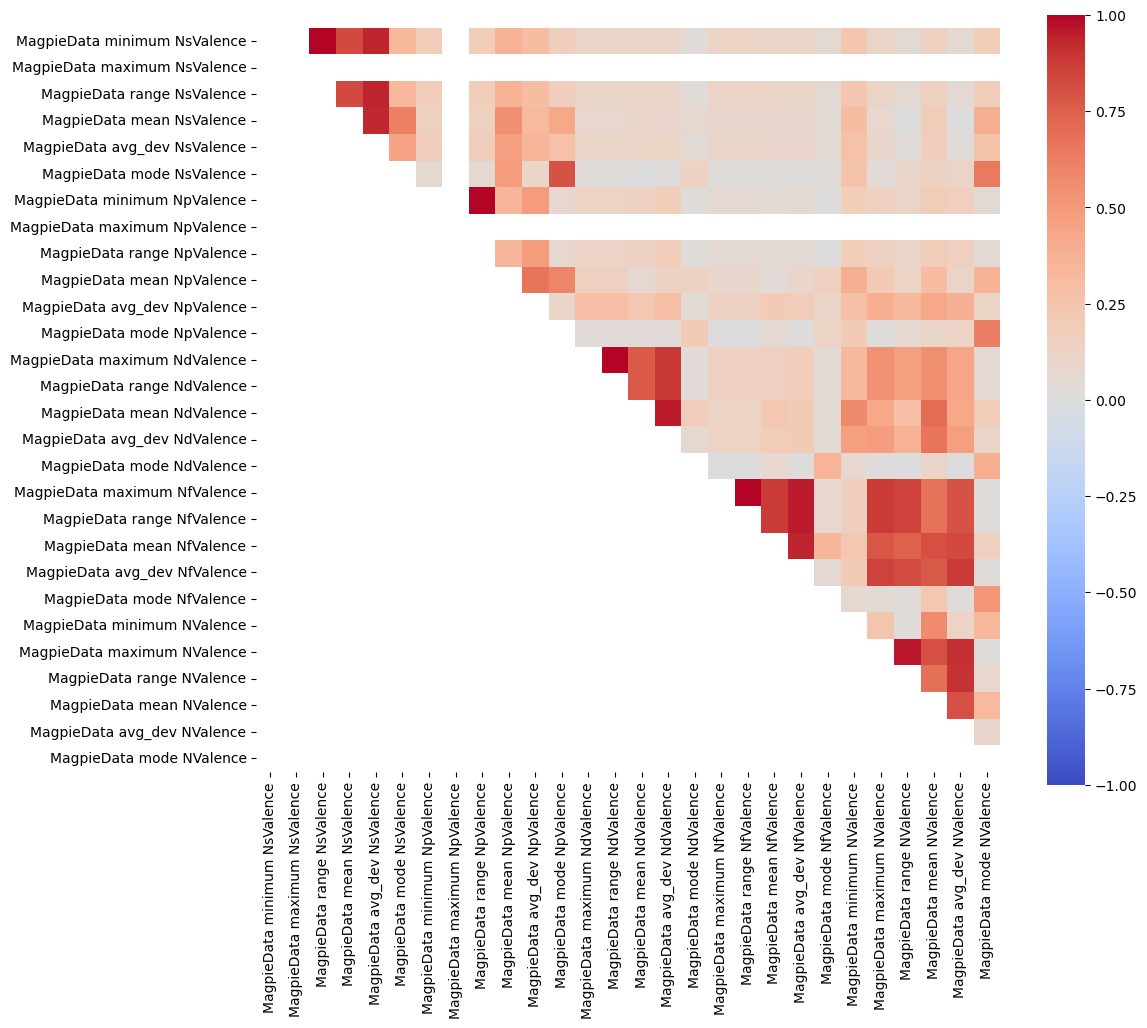

,Feature 1,Feature 2,Correlation
5,MagpieData maximum NdValence,MagpieData range NdValence,1.000000
7,MagpieData maximum NfValence,MagpieData range NfValence,1.000000
0,MagpieData minimum NsValence,MagpieData range NsValence,1.000000
4,MagpieData minimum NpValence,MagpieData range NpValence,1.000000
11,MagpieData maximum NValence,MagpieData range NValence,0.965884
8,MagpieData maximum NfValence,MagpieData avg_dev NfValence,0.955435
9,MagpieData range NfValence,MagpieData avg_dev NfValence,0.955435
6,MagpieData mean NdValence,MagpieData avg_dev NdValence,0.954282
10,MagpieData mean NfValence,MagpieData avg_dev NfValence,0.943474
1,MagpieData minimum NsValence,MagpieData avg_dev NsValence,0.937655


In [12]:
get_corr_mat(encoded_train_h_X[[c for c in encoded_train_h_X.columns if "Valence" in c]], True, 0.9)

In [13]:
cols_to_drop.append("minimum")
cols_to_drop.append("maximum")
cols_to_drop.append("avg_dev")
cols_to_drop.append("range")
cols_to_drop.append("mode")
cols_to_drop.append("valence electrons")

encoded_train_h_X = encoded_train_h_X.drop(columns=[c for c in encoded_train_h_X.columns if "minimum" in c or "maximum" in c or "avg_dev" in c or "range" in c or "mode" in c or "valence electrons" in c]).reset_index(drop=True)
encoded_train_no_ads_X = encoded_train_no_ads_X.drop(columns=[c for c in encoded_train_no_ads_X.columns if "minimum" in c or "maximum" in c or "avg_dev" in c or "range" in c or "mode" in c or "valence electrons" in c]).reset_index(drop=True)

computing corr matrix for 5 features


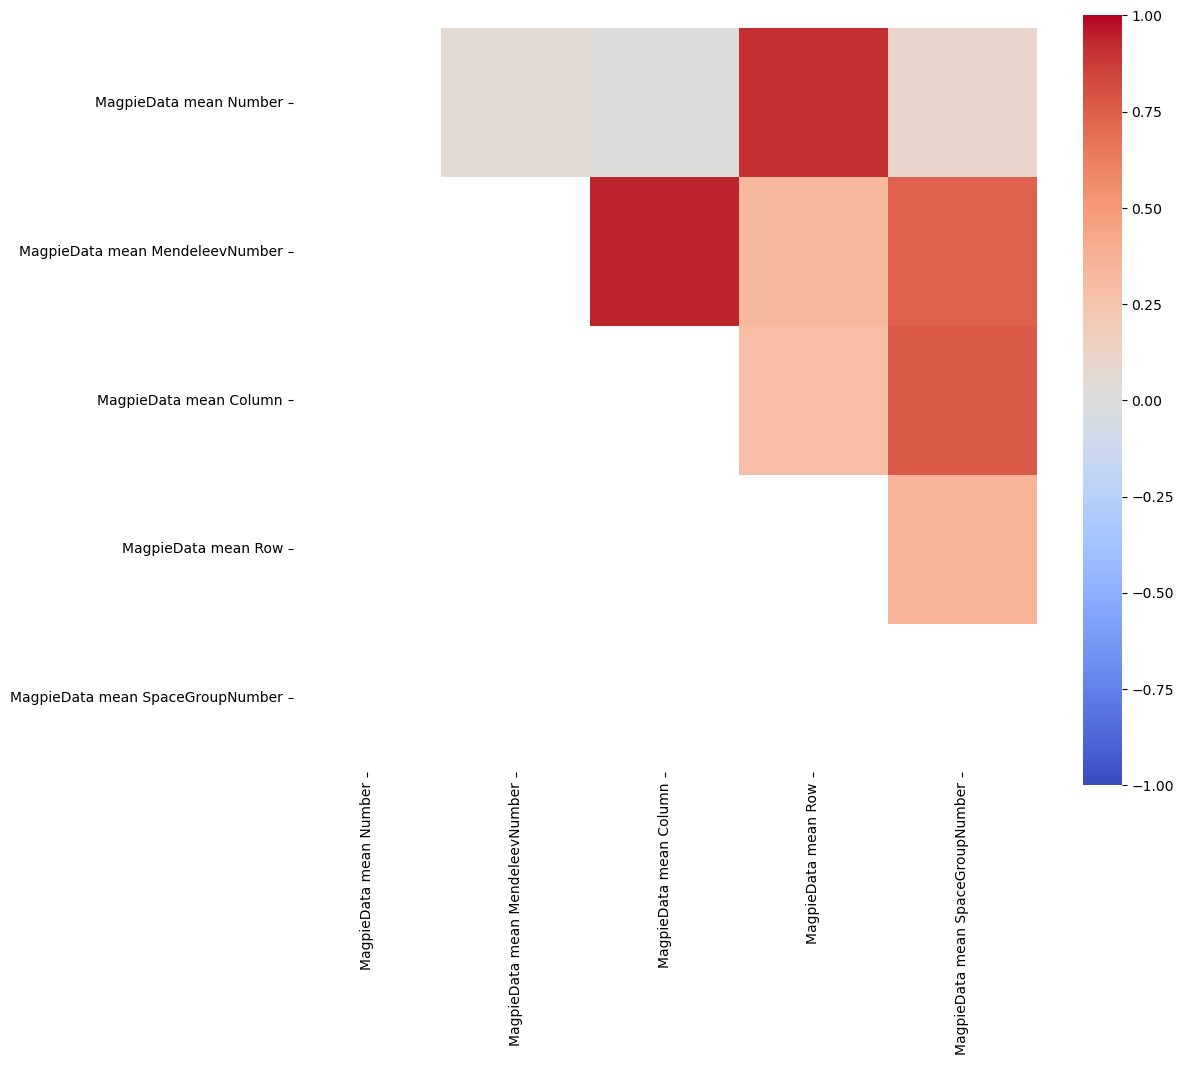

,Feature 1,Feature 2,Correlation
0,MagpieData mean MendeleevNumber,MagpieData mean Column,0.940340
1,MagpieData mean Number,MagpieData mean Row,0.918761


In [14]:
get_corr_mat(encoded_train_h_X[[c for c in encoded_train_h_X.columns if "Column" in c or "Row" in c or "Number" in c]], True, 0.8)

In [15]:
cols_to_drop.append("Column")
cols_to_drop.append("Number")
cols_to_drop.append("Row")

encoded_train_h_X = encoded_train_h_X.drop(columns=[c for c in encoded_train_h_X.columns if "Column" in c or "Number" in c or "Row" in c]).reset_index(drop=True)
encoded_train_h_X = encoded_train_h_X.drop(columns=[c for c in encoded_train_h_X.columns if "Column" in c or "Number" in c or "Row" in c]).reset_index(drop=True)

computing corr matrix for 6 features


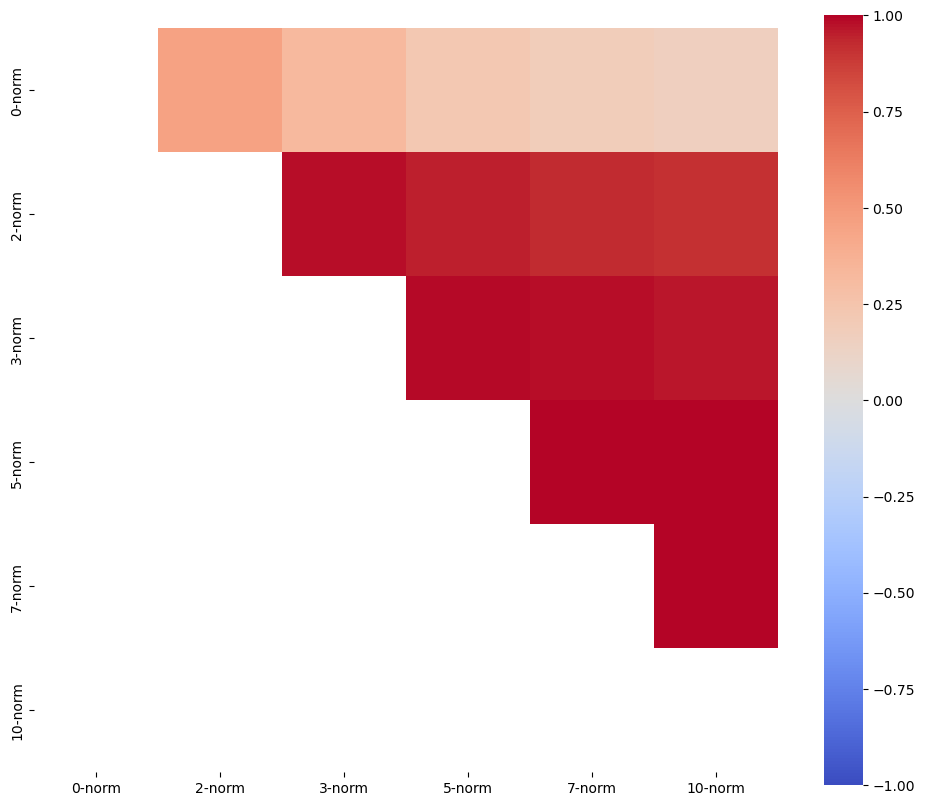

,Feature 1,Feature 2,Correlation
9,7-norm,10-norm,0.998943
5,5-norm,7-norm,0.997968
8,5-norm,10-norm,0.994077
2,3-norm,5-norm,0.988430
0,2-norm,3-norm,0.983685
4,3-norm,7-norm,0.977344
7,3-norm,10-norm,0.967696
1,2-norm,5-norm,0.946316
3,2-norm,7-norm,0.926376
6,2-norm,10-norm,0.911559


In [16]:
get_corr_mat(encoded_train_h_X[[c for c in encoded_train_h_X.columns if "norm" in c ]], True, 0.8)

In [17]:
cols_to_drop.append("norm")

encoded_train_h_X = encoded_train_h_X.drop(columns=[c for c in encoded_train_h_X.columns if "norm" in c]).reset_index(drop=True)
encoded_train_h_X = encoded_train_h_X.drop(columns=[c for c in encoded_train_h_X.columns if "norm" in c]).reset_index(drop=True)

computing corr matrix for 100 features


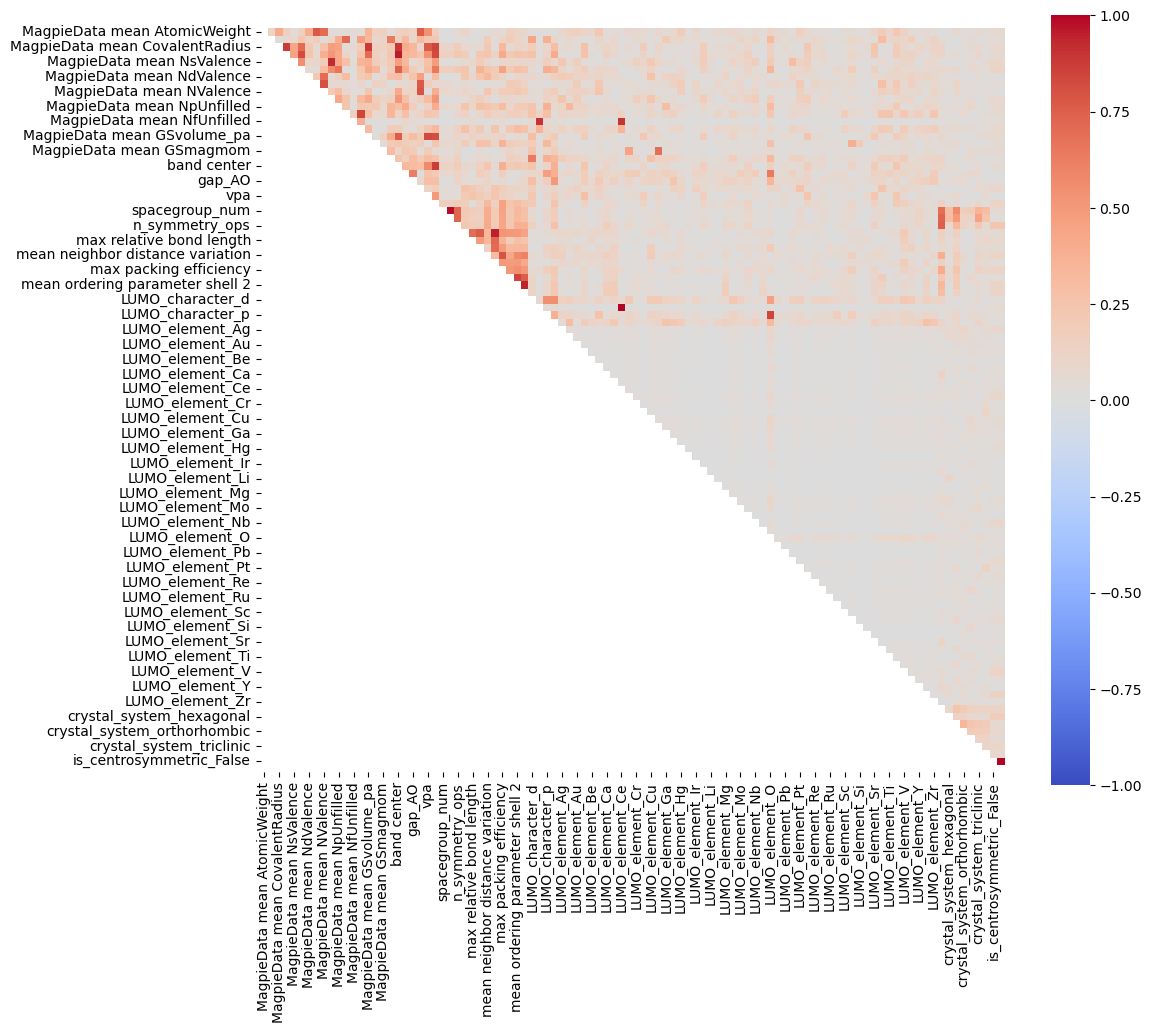

,Feature 1,Feature 2,Correlation
21,is_centrosymmetric_False,is_centrosymmetric_True,1.000000
19,LUMO_character_f,LUMO_element_Ce,1.000000
13,spacegroup_num,crystal_system_int,0.979794
7,MagpieData mean Electronegativity,band center,0.955500
14,mean absolute deviation in relative bond length,mean absolute deviation in relative cell size,0.949431
16,mean ordering parameter shell 2,mean ordering parameter shell 3,0.938860
3,MagpieData mean NsValence,MagpieData mean NsUnfilled,0.923160
18,MagpieData mean NfUnfilled,LUMO_element_Ce,0.901832
17,MagpieData mean NfUnfilled,LUMO_character_f,0.901832
6,MagpieData mean CovalentRadius,band center,0.884865


In [18]:
get_corr_mat(encoded_train_h_X[[c for c in encoded_train_h_X.columns if "" in c ]], True, 0.8)

# Final Clean Up

In [19]:
cols_to_drop

['coulomb matrix eig',
 'HOMO',
 'local difference',
 'minimum',
 'maximum',
 'avg_dev',
 'range',
 'mode',
 'valence electrons',
 'Column',
 'Number',
 'Row',
 'norm']

## Get clean y set

In [20]:
def get_nan_cols_rows(df):
    nan_cols = []
    nan_rows = []

    for row_i, row in df.iterrows():
        for col_i in row.index:
            if pd.isna(row[col_i]):
                if col_i not in nan_cols:
                    nan_cols.append(col_i)
                if row_i not in nan_rows:
                    nan_rows.append(row_i)
    
    return nan_rows, nan_cols

h_nan_rows, h_nan_cols = get_nan_cols_rows(train_h)
no_ads_nan_rows, no_ads_nan_cols = get_nan_cols_rows(train_no_ads)

print("h columns with NaN values:", h_nan_cols)
print("h rows with NaN values:", len(h_nan_rows))

print("no-ads columns with NaN values:", no_ads_nan_cols)
print("no-ads rows with NaN values:", len(no_ads_nan_rows))

encoded_train_h_X = encoded_train_h_X.drop(index=h_nan_rows).reset_index(drop=True)
encoded_train_no_ads_X = encoded_train_no_ads_X.drop(index=no_ads_nan_rows).reset_index(drop=True)

# get cleaned y values
# maybe better to get y column first then drop rows but whatever
train_h_clean = train_h.drop(index=h_nan_rows).reset_index(drop=True)
train_h_y = train_h_clean['y_relaxed']
train_h_y.to_csv("data_clean/train_h_y.csv", index=False)
print(train_h_y.shape)

train_no_ads_clean = train_no_ads.drop(index=no_ads_nan_rows).reset_index(drop=True)
train_no_ads_y = train_no_ads_clean['y_relaxed']
train_no_ads_y.to_csv("data_clean/train_no_ads_y.csv", index=False)
print(train_no_ads_y.shape)

h columns with NaN values: ['minimum local difference in Number', 'maximum local difference in Number', 'range local difference in Number', 'mean local difference in Number', 'avg_dev local difference in Number', 'minimum local difference in MendeleevNumber', 'maximum local difference in MendeleevNumber', 'range local difference in MendeleevNumber', 'mean local difference in MendeleevNumber', 'avg_dev local difference in MendeleevNumber', 'minimum local difference in AtomicWeight', 'maximum local difference in AtomicWeight', 'range local difference in AtomicWeight', 'mean local difference in AtomicWeight', 'avg_dev local difference in AtomicWeight', 'minimum local difference in MeltingT', 'maximum local difference in MeltingT', 'range local difference in MeltingT', 'mean local difference in MeltingT', 'avg_dev local difference in MeltingT', 'minimum local difference in Column', 'maximum local difference in Column', 'range local difference in Column', 'mean local difference in Column', 

## Drop high corr features

In [21]:
h_high_corr_features = get_cols(train_h, cols_to_drop)[0]
no_ads_high_corr_features = get_cols(train_no_ads, cols_to_drop)[0]

print(f"dropped {len(h_high_corr_features)} features from h set")
print(f"dropped {len(no_ads_high_corr_features)} features from no-ads set")

encoded_train_h_X.to_csv("data_clean/train_h_X_v1.csv", index=False)
print(encoded_train_h_X.shape)

encoded_train_no_ads_X.to_csv("data_clean/train_no_ads_X_v1.csv", index=False)
print(encoded_train_no_ads_X.shape)


dropped 198 features from h set
dropped 198 features from no-ads set
(1411, 100)
(12774, 112)


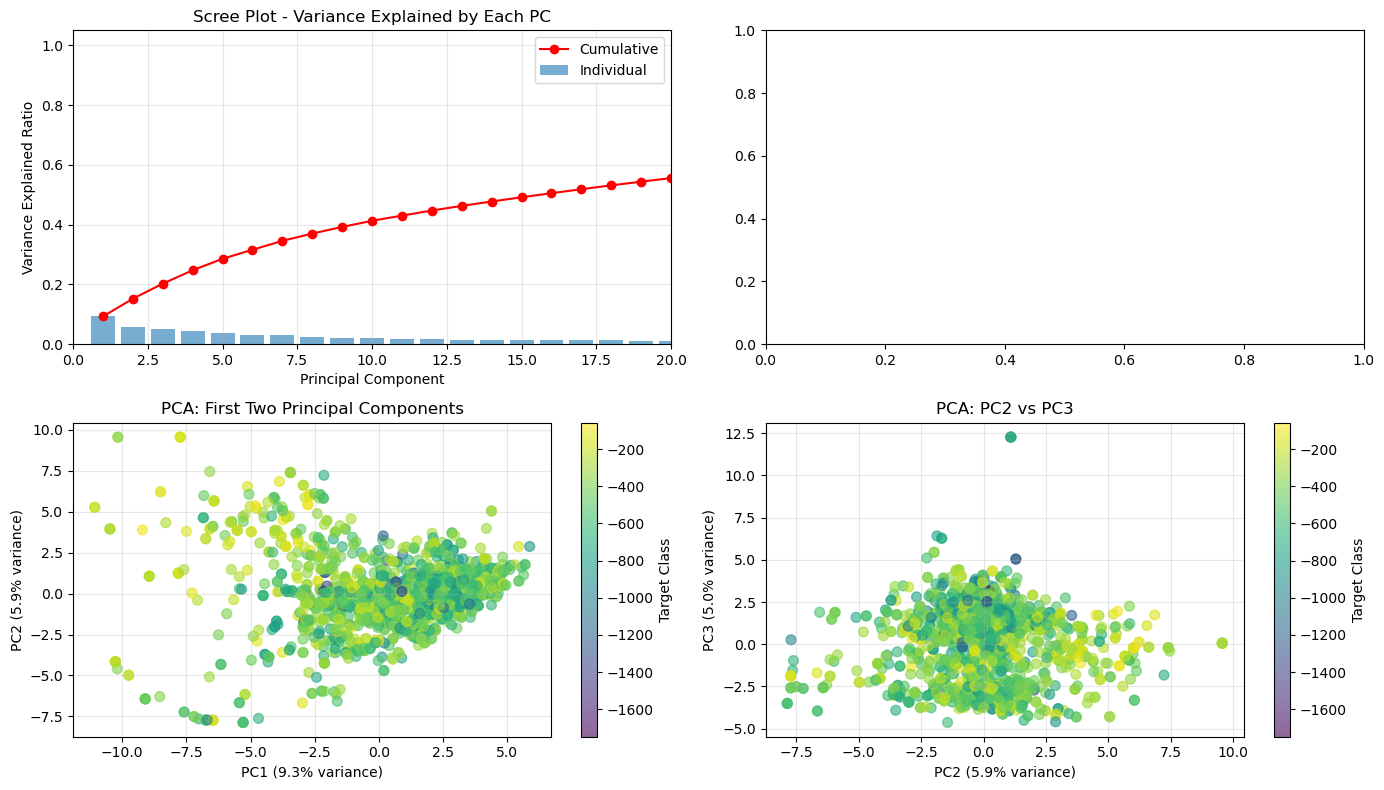

Total variance explained by first 3 PCs: 20.25%
Number of PCs needed for 95% variance: 60

Variance per PC (first 10):
  PC1: 9.30%
  PC2: 5.92%
  PC3: 5.03%
  PC4: 4.50%
  PC5: 3.82%
  PC6: 3.04%
  PC7: 2.96%
  PC8: 2.45%
  PC9: 2.22%
  PC10: 2.05%


In [42]:
# create a PCA plot
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = encoded_train_h_X.values
y = train_h_y.values

# Standardize features (important for PCA!)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# 1. Scree plot - variance explained
ax1 = axes[0, 0]
variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_ratio)
ax1.bar(range(1, len(variance_ratio) + 1), variance_ratio, alpha=0.6, label='Individual')
ax1.plot(range(1, len(variance_ratio) + 1), cumulative_variance, 'ro-', label='Cumulative')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Variance Explained Ratio')
ax1.set_title('Scree Plot - Variance Explained by Each PC')
ax1.legend()
ax1.set_xlim(0, 20)  # Show first 20 components
ax1.grid(True, alpha=0.3)

# 2. 2D scatter plot (PC1 vs PC2)
ax2 = axes[1, 0]
scatter = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.6, s=50)
ax2.set_xlabel(f'PC1 ({variance_ratio[0]:.1%} variance)')
ax2.set_ylabel(f'PC2 ({variance_ratio[1]:.1%} variance)')
ax2.set_title('PCA: First Two Principal Components')
plt.colorbar(scatter, ax=ax2, label='Target Class')
ax2.grid(True, alpha=0.3)

# 3. 2D scatter plot (PC2 vs PC3)
ax3 = axes[1, 1]
scatter2 = ax3.scatter(X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis', alpha=0.6, s=50)
ax3.set_xlabel(f'PC2 ({variance_ratio[1]:.1%} variance)')
ax3.set_ylabel(f'PC3 ({variance_ratio[2]:.1%} variance)')
ax3.set_title('PCA: PC2 vs PC3')
plt.colorbar(scatter2, ax=ax3, label='Target Class')
ax3.grid(True, alpha=0.3)

# 4. Feature loadings heatmap for first 3 PCs
# ax4 = axes[1, 1]
# # Show top 20 features by absolute loading
# n_features_to_show = 20
# loadings = pca.components_[:3, :]  # First 3 PCs
# top_features = np.argsort(np.abs(loadings).sum(axis=0))[-n_features_to_show:]
# feature_names = encoded_train_h_X.columns
# sns.heatmap(loadings[:, top_features].T, cmap='RdBu_r', center=0, 
#             ax=ax4, cbar_kws={'label': 'Loading'}, 
#             yticklabels=[feature_names[i] for i in top_features],
#             xticklabels=['PC1', 'PC2', 'PC3'])
# ax4.set_title(f'Top {n_features_to_show} Feature Loadings')
# ax4.set_xlabel('Principal Component')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Total variance explained by first 3 PCs: {cumulative_variance[2]:.2%}")
print(f"Number of PCs needed for 95% variance: {np.argmax(cumulative_variance >= 0.95) + 1}")
print(f"\nVariance per PC (first 10):")
for i in range(min(10, len(variance_ratio))):
    print(f"  PC{i+1}: {variance_ratio[i]:.2%}")